# CSV/Excel 데이터 분석 Agent

Pandas DataFrame 을 활용하여 분석을 수행하는 Agent 를 생성할 수 있습니다.

CSV/Excel 데이터로부터 Pandas DataFrame 객체를 생성할 수 있으며, 이를 활용하여 Agent 가 Pandas query 를 생성하여 분석을 수행할 수 있습니다.

In [1]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [4]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH15-Agent-Toolkits")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH15-Agent-Toolkits


In [36]:
import pandas as pd

df = pd.read_csv("./data/titanic.csv")  # CSV 파일을 읽습니다.
# df = pd.read_excel("./data/titanic.xlsx") # 엑셀 파일도 읽을 수 있습니다.
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [38]:
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain.agents.agent_types import AgentType
from langchain_openai import ChatOpenAI
from langchain_teddynote.messages import AgentStreamParser
import seaborn as sns

sns.set_style("white")

agent = create_pandas_dataframe_agent(
    ChatOpenAI(model="gpt-4o-mini", temperature=0),
    df,
    verbose=False,
    agent_type=AgentType.OPENAI_FUNCTIONS,
    allow_dangerous_code=True,
)

stream_parser = AgentStreamParser()

In [39]:
def ask(query):
    # 질의에 대한 답변을 출력합니다.
    response = agent.stream({"input": query})

    for step in response:
        stream_parser.process_agent_steps(step)

In [40]:
ask("몇 개의 행이 있어?")

[도구 호출]
Tool: python_repl_ast
query: len(df)
Log: 
Invoking: `python_repl_ast` with `{'query': 'len(df)'}`



[관찰 내용]
Observation: 891
[최종 답변]
데이터프레임 `df`에는 총 891개의 행이 있습니다.


In [41]:
ask("남자와 여자의 생존율의 차이는 몇이야?")

[도구 호출]
Tool: python_repl_ast
query: male_survival_rate = df[df['Sex'] == 'male']['Survived'].mean()
female_survival_rate = df[df['Sex'] == 'female']['Survived'].mean()
survival_rate_difference = female_survival_rate - male_survival_rate
survival_rate_difference
Log: 
Invoking: `python_repl_ast` with `{'query': "male_survival_rate = df[df['Sex'] == 'male']['Survived'].mean()\nfemale_survival_rate = df[df['Sex'] == 'female']['Survived'].mean()\nsurvival_rate_difference = female_survival_rate - male_survival_rate\nsurvival_rate_difference"}`



[관찰 내용]
Observation: 0.5531300709799203
[최종 답변]
남자와 여자의 생존율의 차이는 약 0.55입니다. 즉, 여자의 생존율이 남자보다 약 55.3% 더 높습니다.


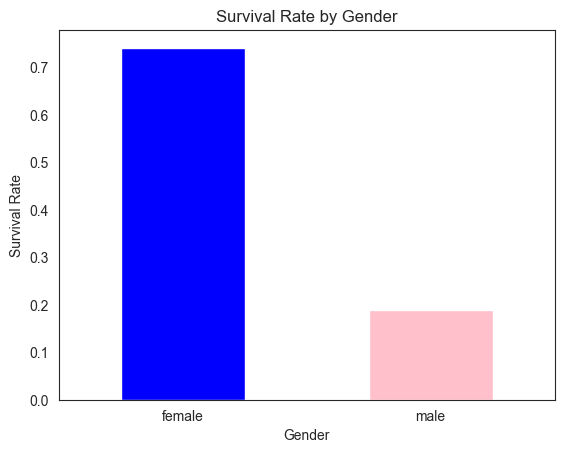

[도구 호출]
Tool: python_repl_ast
query: import pandas as pd
import matplotlib.pyplot as plt

# 남자와 여자 승객의 생존율 계산
survival_rate = df.groupby('Sex')['Survived'].mean()

# barplot 시각화
survival_rate.plot(kind='bar', color=['blue', 'pink'])
plt.title('Survival Rate by Gender')
plt.xlabel('Gender')
plt.ylabel('Survival Rate')
plt.xticks(rotation=0)
plt.show()
Log: 
Invoking: `python_repl_ast` with `{'query': "import pandas as pd\nimport matplotlib.pyplot as plt\n\n# 남자와 여자 승객의 생존율 계산\nsurvival_rate = df.groupby('Sex')['Survived'].mean()\n\n# barplot 시각화\nsurvival_rate.plot(kind='bar', color=['blue', 'pink'])\nplt.title('Survival Rate by Gender')\nplt.xlabel('Gender')\nplt.ylabel('Survival Rate')\nplt.xticks(rotation=0)\nplt.show()"}`



[관찰 내용]
Observation: 
[최종 답변]
남자 승객과 여자 승객의 생존율을 계산한 후, 바 차트로 시각화한 결과를 확인할 수 있습니다. 차트는 남성과 여성의 생존율을 비교하여 보여줍니다.


In [42]:
ask("남자 승객과 여자 승객의 생존율을 구한뒤 barplot 차트로 시각화 해줘")

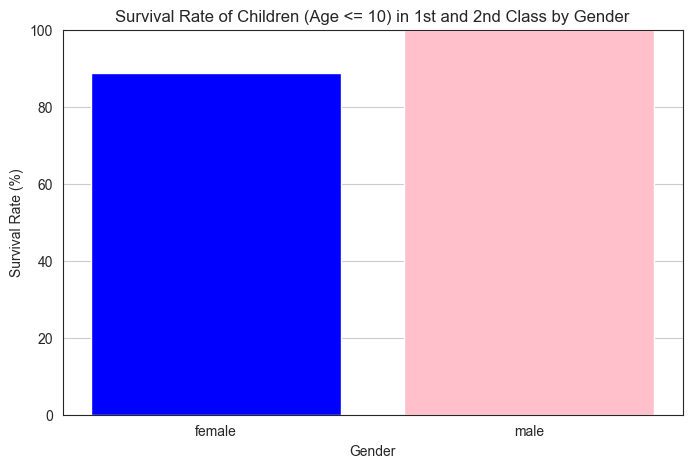

[도구 호출]
Tool: python_repl_ast
query: import pandas as pd
import matplotlib.pyplot as plt

# 1, 2등급에 탑승한 10세 이하 어린 아이 필터링
children = df[(df['Pclass'].isin([1, 2])) & (df['Age'] <= 10)]

# 성별별 생존율 계산
survival_rate = children.groupby('Sex')['Survived'].mean() * 100

# 시각화
plt.figure(figsize=(8, 5))
plt.bar(survival_rate.index, survival_rate.values, color=['blue', 'pink'])
plt.title('Survival Rate of Children (Age <= 10) in 1st and 2nd Class by Gender')
plt.xlabel('Gender')
plt.ylabel('Survival Rate (%)')
plt.ylim(0, 100)
plt.grid(axis='y')
plt.show()
Log: 
Invoking: `python_repl_ast` with `{'query': "import pandas as pd\nimport matplotlib.pyplot as plt\n\n# 1, 2등급에 탑승한 10세 이하 어린 아이 필터링\nchildren = df[(df['Pclass'].isin([1, 2])) & (df['Age'] <= 10)]\n\n# 성별별 생존율 계산\nsurvival_rate = children.groupby('Sex')['Survived'].mean() * 100\n\n# 시각화\nplt.figure(figsize=(8, 5))\nplt.bar(survival_rate.index, survival_rate.values, color=['blue', 'pink'])\nplt.title('Survival Rate of Children (Age <= 10)

In [43]:
ask("1,2등급에 탑승한 10세 이하 어린 아이의 성별별 생존율을 구하고 시각화 하세요")